In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
df=pd.read_csv("Cleaned.csv").drop("Unnamed: 0",axis=1)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,agex
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,40-70
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,40-70
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,40-70
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Less_than_40
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,40-70


In [3]:
data=df.drop(["CustomerId","Surname"],axis=1)
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'agex'],
      dtype='object')

#### Feature Engineer

In [4]:
data[["Tenure","NumOfProducts","HasCrCard","IsActiveMember"]]=data[["Tenure","NumOfProducts","HasCrCard","IsActiveMember"]].astype("object")

In [5]:
obj_cols=data.select_dtypes("object").columns
obj_cols

Index(['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'agex'],
      dtype='object')

In [6]:
for col in obj_cols:
    a=df[col].value_counts()
    print(a)

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
Gender
Male      5457
Female    4543
Name: count, dtype: int64
Tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: count, dtype: int64
NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64
HasCrCard
1    7055
0    2945
Name: count, dtype: int64
IsActiveMember
1    5151
0    4849
Name: count, dtype: int64
agex
Less_than_40    5987
40-70           3862
over_70          151
Name: count, dtype: int64


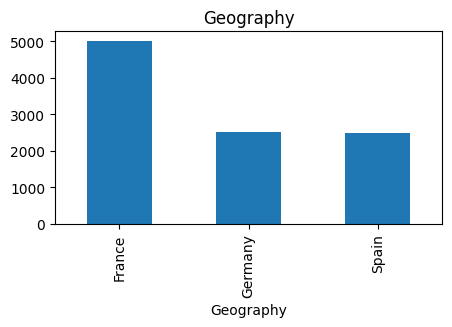

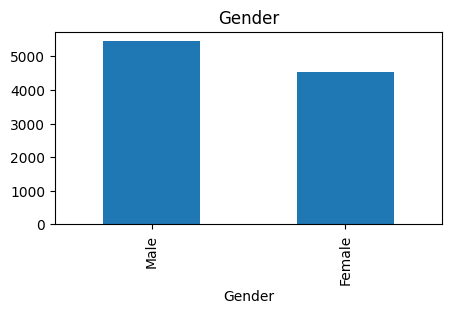

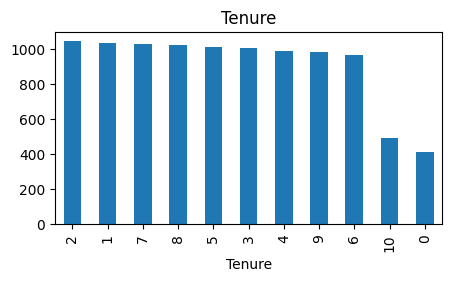

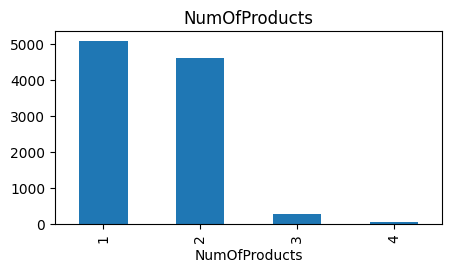

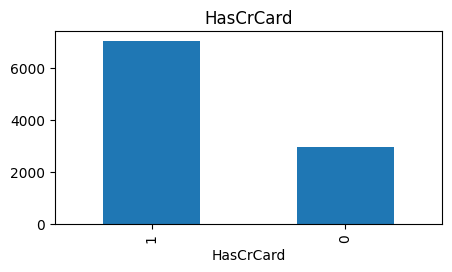

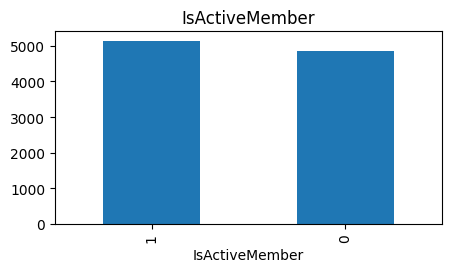

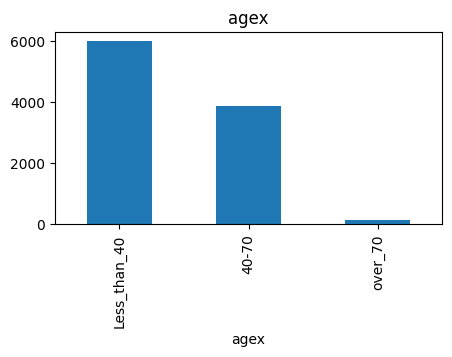

In [7]:
for col in obj_cols:
    plt.figure(figsize=(5,2.5))
    a=df[col].value_counts().plot.bar()
    plt.title(f"{col}")
    

#### Regrouping categorical features

In [8]:
df["NumOfProducts"]=df["NumOfProducts"].map({1:"1_3_or_4_products",2:"2_products",3:"1_3_or_4_products",4:"1_3_or_4_products"})

In [9]:
df["NumOfProducts"].value_counts(normalize=True)

NumOfProducts
1_3_or_4_products    0.541
2_products           0.459
Name: proportion, dtype: float64

In [10]:
df["agex"]=df["agex"].map({"Less_than_40":"not_40_and_70","over_70":"not_40_and_70","40-70":"40-70"})

In [11]:
df["agex"].value_counts(normalize=True)

agex
not_40_and_70    0.6138
40-70            0.3862
Name: proportion, dtype: float64

In [12]:
df["Tenure"]=df["Tenure"].map({
    1:"1year",
    2:'2year',
    3:'3year',
    4:'4year',
    5:'5year',
    6:'6year',
    7:'7year',
    8:'8year',
    9:'9year',
    0:'0_or_10_year',
    10:'0_or_10_year',
})

In [13]:
df.Tenure.value_counts()

Tenure
2year           1048
1year           1035
7year           1028
8year           1025
5year           1012
3year           1009
4year            989
9year            984
6year            967
0_or_10_year     903
Name: count, dtype: int64

In [14]:
#df["Geography"]=df["Geography"].map({"France":"Others","Germany":"Germany","Spain":"Others"})

In [15]:
#df.Geography.value_counts()

In [16]:
X=df[["Geography","Gender","NumOfProducts","IsActiveMember","agex","Tenure","Balance","EstimatedSalary","HasCrCard"]]
y=df["Exited"]

#### Data Transformation

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2025)

In [18]:
from sklearn.preprocessing import LabelEncoder
for col in ["Geography","Gender","NumOfProducts","agex","Tenure","HasCrCard"]:
    la=LabelEncoder()
    X_train[col]=la.fit_transform(X_train[col])
    X_test[col]=la.transform(X_test[col])

In [19]:
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_test_std=std.transform(X_test)

## DecisionTree

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier as dtc
params={
    "criterion":["gini","entropy","log_loss"],
   "max_depth":[2,5,10,15,20],
    "min_samples_leaf":[15,20,25]
}
grid=GridSearchCV(dtc(class_weight="balanced"),params)
grid.fit(X_train_std,y_train)

C:\Users\Kun Bi\anaconda3\envs\Data_Science\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 5, 10, 15, 20],
                         'min_samples_leaf': [15, 20, 25]})

In [21]:
best_params=grid.best_params_
best_params

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 15}

In [22]:
from sklearn.tree import DecisionTreeClassifier as dtc
dt=dtc(**best_params,class_weight="balanced")
dt.fit(X_train_std,y_train)
print(f"Train Accuracy is {dt.score(X_train_std,y_train)}")
print(f"Test Accuracy is {dt.score(X_test_std,y_test)}")

Train Accuracy is 0.79925
Test Accuracy is 0.7975


#### Model Evaluation

In [23]:
from sklearn.metrics import confusion_matrix
y_test_pred=dt.predict(X_test_std)
print(confusion_matrix(y_test,y_test_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

[[1358  235]
 [ 170  237]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1593
           1       0.50      0.58      0.54       407

    accuracy                           0.80      2000
   macro avg       0.70      0.72      0.70      2000
weighted avg       0.81      0.80      0.80      2000



#### Precision-Recall curve

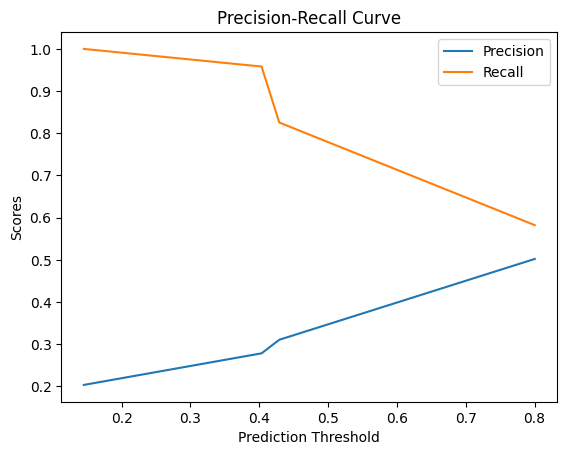

In [24]:
from sklearn.metrics import precision_recall_curve
p_curve,r_curve, t_curve=precision_recall_curve(y_test,dt.predict_proba(X_test_std)[:,1])
plt.plot(t_curve,p_curve[:-1],label="Precision")
plt.plot(t_curve,r_curve[:-1],label="Recall")
plt.xlabel("Prediction Threshold")
plt.ylabel("Scores")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()

#### ROC Curve & AUC

C:\Users\Kun Bi\anaconda3\envs\Data_Science\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


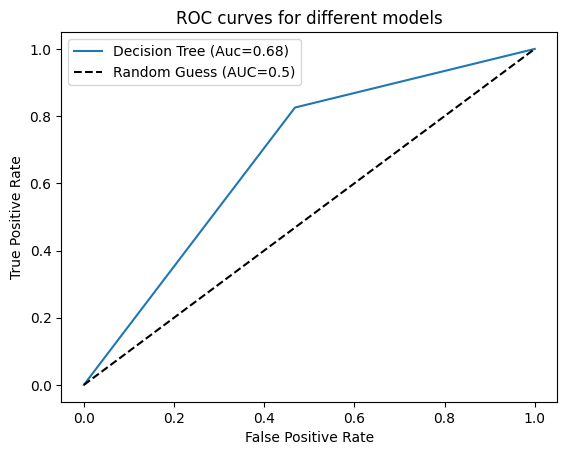

In [25]:
from sklearn.metrics import roc_curve, auc
y_probs=dt.predict_proba(X_test)[:,1]
fpr,tpr,threasholds=roc_curve(y_test,y_probs)
auc_score=auc(fpr,tpr)
plt.plot(fpr,tpr,label=f"Decision Tree (Auc={auc_score:.2f})")
plt.plot([0,1],[0,1],"k--",label="Random Guess (AUC=0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for different models")
plt.legend()
plt.show()

#### The most important features

In [26]:
dt.feature_importances_

array([0.        , 0.        , 0.39672606, 0.        , 0.60327394,
       0.        , 0.        , 0.        , 0.        ])

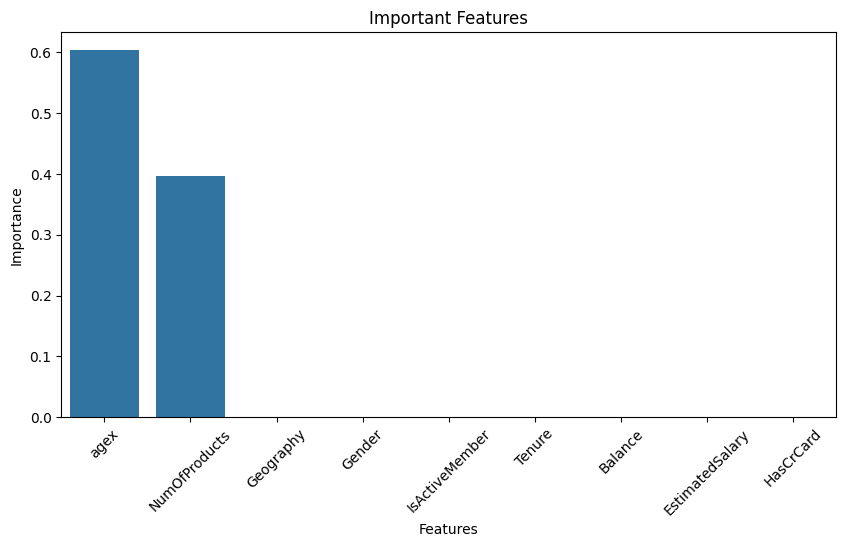

In [27]:
fm=pd.DataFrame({"Features":X.columns,"Importance":dt.feature_importances_})

plt.figure(figsize=(10,5))
sns.barplot(data=fm.sort_values("Importance",ascending=False),x="Features",y="Importance")
plt.xticks(rotation=45)
plt.title("Important Features")
plt.show()

#### Retrain the mode with the most important features.

In [28]:
X=df[["agex","NumOfProducts"]]
y=df["Exited"]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2025)
for col in ["agex","NumOfProducts"]:
    from sklearn.preprocessing import LabelEncoder
    la=LabelEncoder()
    X_train[col]=la.fit_transform(X_train[col])
    X_test[col]=la.transform(X_test[col])
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
X_train_std=std.fit_transform(X_train)
X_test_std=std.transform(X_test)

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier as dtc
params={
    "criterion":["gini","entropy","log_loss"],
    "max_depth":[2,5,10,15,20],
    "min_samples_leaf":[5,10,15,20,25,30,35,40]
}
grid=GridSearchCV(dtc(class_weight="balanced"),params)
grid.fit(X_train_std,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 5, 10, 15, 20],
                         'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40]})

In [30]:
best_params=grid.best_params_
best_params

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5}

In [31]:
from sklearn.tree import DecisionTreeClassifier as dtc
dt=dtc(**best_params,class_weight="balanced")
dt.fit(X_train_std,y_train)
print(f"Train Accuracy is {dt.score(X_train_std,y_train)}")
print(f"Test Accuracy is {dt.score(X_test_std,y_test)}")

Train Accuracy is 0.79925
Test Accuracy is 0.7975


In [32]:
from sklearn.metrics import confusion_matrix
y_test_pred=dt.predict(X_test_std)
print(confusion_matrix(y_test,y_test_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

[[1358  235]
 [ 170  237]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1593
           1       0.50      0.58      0.54       407

    accuracy                           0.80      2000
   macro avg       0.70      0.72      0.70      2000
weighted avg       0.81      0.80      0.80      2000



#### Precision-Recall Curve

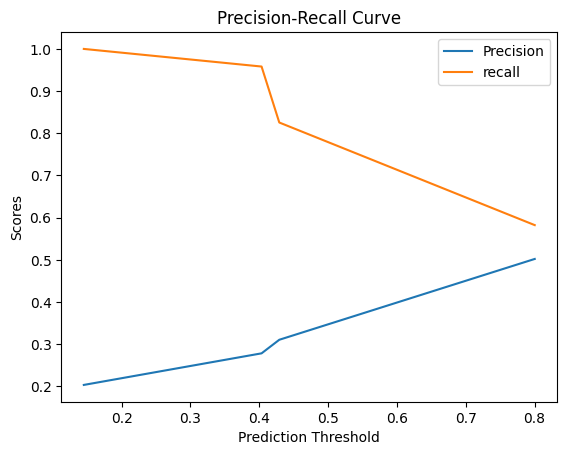

In [33]:
from sklearn.metrics import precision_recall_curve
p_curve,r_curve, t_curve=precision_recall_curve(y_test,dt.predict_proba(X_test_std)[:,1])
plt.plot(t_curve,p_curve[:-1],label="Precision")
plt.plot(t_curve,r_curve[:-1],label="recall")
plt.xlabel("Prediction Threshold")
plt.ylabel("Scores")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()

#### ROC Curve & AUC

C:\Users\Kun Bi\anaconda3\envs\Data_Science\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


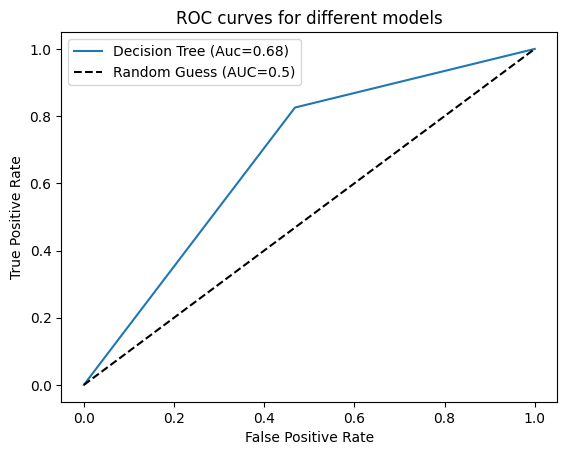

In [34]:
from sklearn.metrics import roc_curve, auc
y_probs=dt.predict_proba(X_test)[:,1]
fpr,tpr,threasholds=roc_curve(y_test,y_probs)
auc_score=auc(fpr,tpr)
plt.plot(fpr,tpr,label=f"Decision Tree (Auc={auc_score:.2f})")
plt.plot([0,1],[0,1],"k--",label="Random Guess (AUC=0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for different models")
plt.legend()
plt.show()